In [1]:
!pip install ultralytics
!pip install pycuda

import pycuda.driver as cuda
import os
from ultralytics import YOLO
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 18.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
DATASET_PATH = '/kaggle/input/facial-feature-extraction-dataset'
DATA_YAML = os.path.join(DATASET_PATH, 'Facial Feature Extraction Dataset/data.yaml')

In [3]:
!nvidia-smi

Wed Jan 22 06:59:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# !pip show accelerate
# !pip install git+https://github.com/huggingface/accelerate

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

!source ~/.bashrc

In [6]:
# autocomplete
%config Completer.use_jedi = False

In [7]:
class FeatureExtractionModel:
    def __init__(self, yolo_model_name):
        self.model = YOLO(yolo_model_name)
        
    def train_model(self):
        """
        Initialize and train YOLOv8 model with specified parameters
        Returns:
            training results
        """
        cuda.init()
        device_count = cuda.Device.count()
        device = ','.join(str(i) for i in range(device_count)) if device_count > 0 else 'cpu'

        # Initialize the wandb logging before training
        # wandb.init(project="yolo_training", config={"epochs": 20, "batch_size": 16})
        results = self.model.train(
            data=DATA_YAML,       # data.yaml file from Roboflow
            epochs=20,            # number of epochs
            imgsz=640,            # image size
            batch=32,             # batch size
            name='yolov8_custom', # folder name for training results
            device=device,        # '0' for GPU, 'cpu' for CPU
            patience=50,          # early stopping patience
            save=True,            # save best model
            pretrained=True,      # use pretrained weights
            plots=True,           # save training plots
            cache=True,           # enable caching
            verbose=True,         # Enable verbose logging
            workers=32
        )
        
        return results
    
    def evaluate_model(self, model_path):
        """
        Evaluate trained model using validation dataset
        Args:
            model_path: path to the trained model weights
        Returns:
            evaluation metrics
        """
        model = YOLO(model_path)
        metrics = model.val()
        return metrics
    
    def visualize_metrics(self, metrics, result_dir):
        """
        Create visualizations for model performance metrics
        Args:
            metrics: model evaluation metrics
        """
        # Create a DataFrame for metrics
        metrics_dict = {
            'Metric': ['Precision', 'Recall', 'mAP50', 'mAP50-95'],
            'Value': [
                metrics.results_dict['metrics/precision(B)'],
                metrics.results_dict['metrics/recall(B)'],
                metrics.results_dict['metrics/mAP50(B)'],
                metrics.results_dict['metrics/mAP50-95(B)']
            ]
        }
        df_metrics = pd.DataFrame(metrics_dict)
        
        # Create bar plot
        # plt.figure(figsize=(10, 6))
        # sns.barplot(data=df_metrics, x='Metric', y='Value')
        # plt.title('Model Performance Metrics')
        # plt.ylabel('Score')
        # plt.ylim(0, 1)
        # plt.xticks(rotation=45)
        # plt.tight_layout()
        
        # Display class-wise mAP
        print("\nClass-wise mAP Scores:")
        for class_name, map_score in zip(metrics.names.values(), metrics.maps):
            print(f"{class_name}: {map_score:.3f}")

        img = Image.open(os.path.join(result_dir, "F1_curve.png"))
        plt.figure(figsize=(12, 8))
        plt.axis('off')
        plt.title('F1_curve')
        plt.imshow(img)

        img = Image.open(os.path.join(result_dir, "PR_curve.png"))
        plt.figure(figsize=(12, 8))
        plt.axis('off')
        plt.title('PR_curve')
        plt.imshow(img)

        img = Image.open(os.path.join(result_dir, "P_curve.png"))
        plt.figure(figsize=(12, 8))
        plt.axis('off')
        plt.title('P_curve')
        plt.imshow(img)

        img = Image.open(os.path.join(result_dir, "R_curve.png"))
        plt.figure(figsize=(12, 8))
        plt.axis('off')
        plt.title('R_curve')
        plt.imshow(img)

        img = Image.open(os.path.join(result_dir, "confusion_matrix.png"))
        plt.figure(figsize=(16, 12))
        plt.axis('off')
        plt.title('confusion_matrix')
        plt.imshow(img)

        img = Image.open(os.path.join(result_dir, "confusion_matrix_normalized.png"))
        plt.figure(figsize=(16, 12))
        plt.axis('off')
        plt.title('confusion_matrix_normailized')
        plt.imshow(img)

        img = Image.open(os.path.join(result_dir, "labels.jpg"))
        plt.figure(figsize=(16, 16))
        plt.axis('off')
        plt.title('labels')
        plt.imshow(img)

        img = Image.open(os.path.join(result_dir, "labels_correlogram.jpg"))
        plt.figure(figsize=(16, 16))
        plt.axis('off')
        plt.title('labels_correlogram')
        plt.imshow(img)

        img = Image.open(os.path.join(result_dir, "results.png"))
        plt.figure(figsize=(16, 12))
        plt.axis('off')
        plt.title('results')
        plt.imshow(img)

        plt.show()
        

In [8]:
def main():
    # Verify data path
    if not os.path.exists(DATA_YAML):
        raise FileNotFoundError(f"data.yaml file not found: {DATA_YAML}")
    
    print("🚀 Training started...")
    print(f"📁 Dataset path: {DATASET_PATH}")
    
    # Train model
    model = FeatureExtractionModel('yolov8m.pt')
    model.train_model()
    
    # Evaluate best model
    best_model_path = f'runs/detect/yolov8_custom/weights/best.pt'
    best_model_dir = f'runs/detect/yolov8_custom'
    metrics = model.evaluate_model(best_model_path)
    
    print("\n✨ Training completed!")
    print(f"💾 Best model saved at: {best_model_path}")
    
    print("\n📊 Model Performance Summary:")
    print("=" * 50)
    print(f"Precision: {metrics.results_dict['metrics/precision(B)']:.3f}")
    print(f"Recall: {metrics.results_dict['metrics/recall(B)']:.3f}")
    print(f"mAP50: {metrics.results_dict['metrics/mAP50(B)']:.3f}")
    print(f"mAP50-95: {metrics.results_dict['metrics/mAP50-95(B)']:.3f}")
    print("=" * 50)

    model.visualize_metrics(metrics, best_model_dir)
    

🚀 Training started...
📁 Dataset path: /kaggle/input/facial-feature-extraction-dataset


100%|██████████| 49.7M/49.7M [00:00<00:00, 269MB/s]


Ultralytics 8.3.65 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/input/facial-feature-extraction-dataset/Facial Feature Extraction Dataset/data.yaml, epochs=20, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=0,1, workers=32, project=None, name=yolov8_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, ret

100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

val: Scanning /kaggle/input/facial-feature-extraction-dataset/Facial Feature Extraction Dataset/valid/labels... 126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<00:00, 643.24it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/facial-feature-extraction-dataset/Facial Feature Extraction Dataset/valid is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


                   all        126        685       0.99      0.993      0.995       0.85
                   eye        126        138      0.986      0.996      0.995      0.821
               eyebrow        126        144      0.979       0.99      0.994      0.798
                   lip        126        129      0.997          1      0.995      0.883
        mustache-beard        126        146      0.988      0.979      0.994      0.863
                  nose        126        128          1      0.999      0.995      0.883


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 23.0ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val

✨ Training completed!
💾 Best model saved at: runs/detect/yolov8_custom/weights/best.pt

📊 Model Performance Summary:
Precision: 0.990
Recall: 0.993
mAP50: 0.995
mAP50-95: 0.850

Class-wise mAP Scores:
eye: 0.821
eyebrow: 0.798
lip: 0.883
mustache-beard: 0.863
nose: 0.883


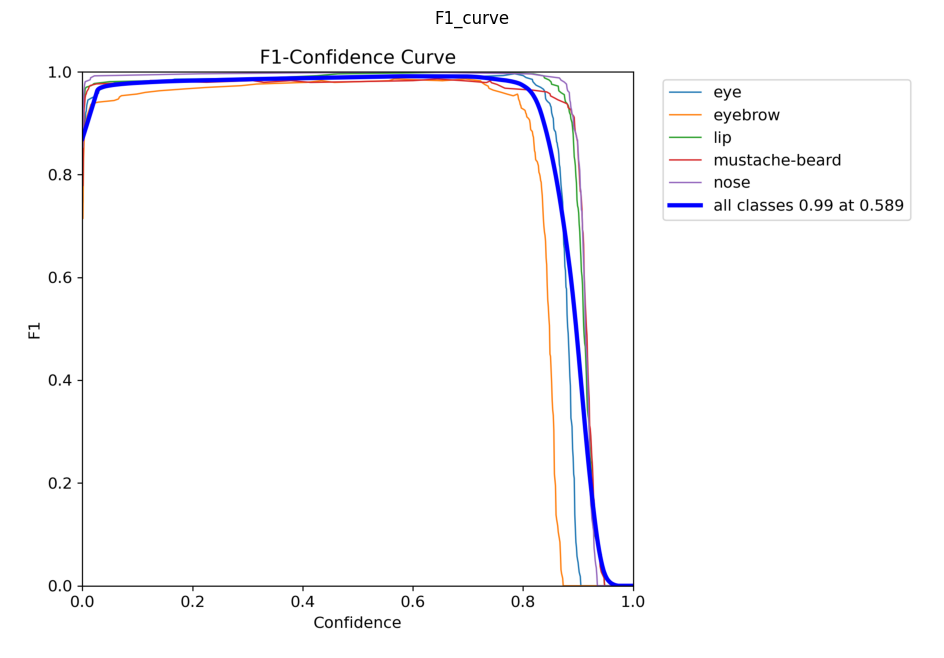

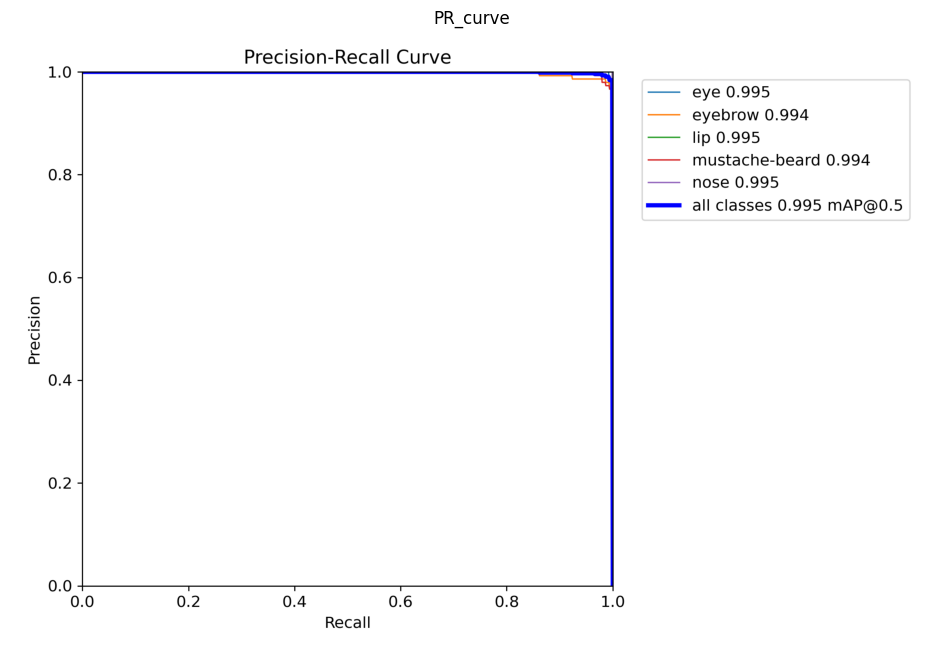

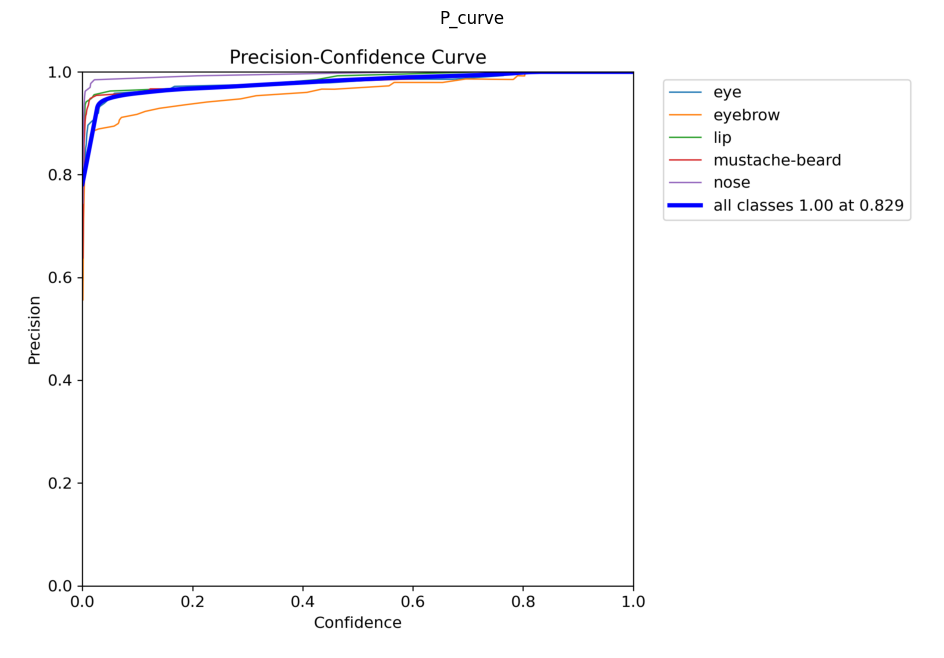

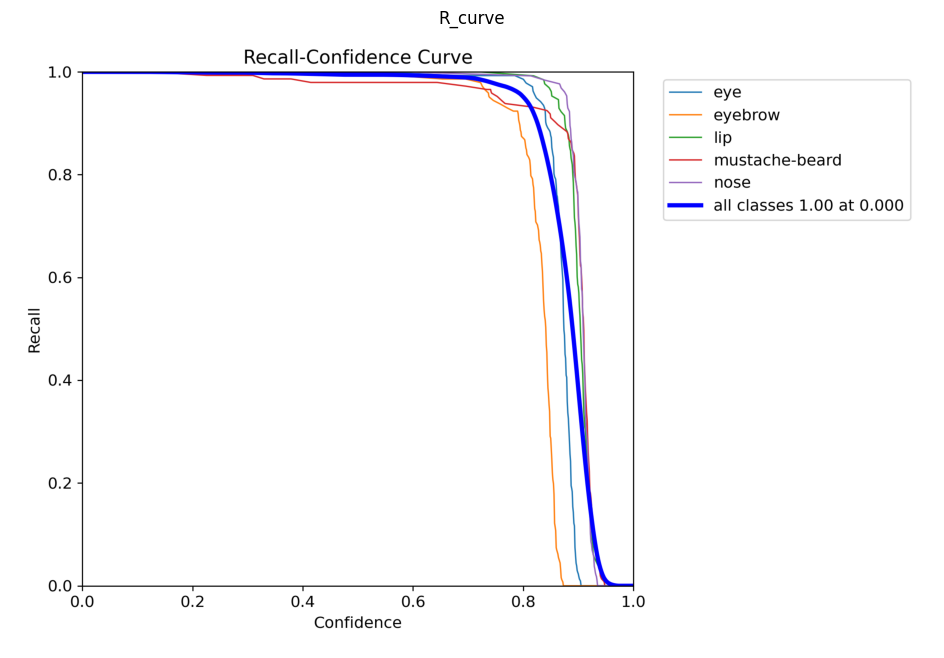

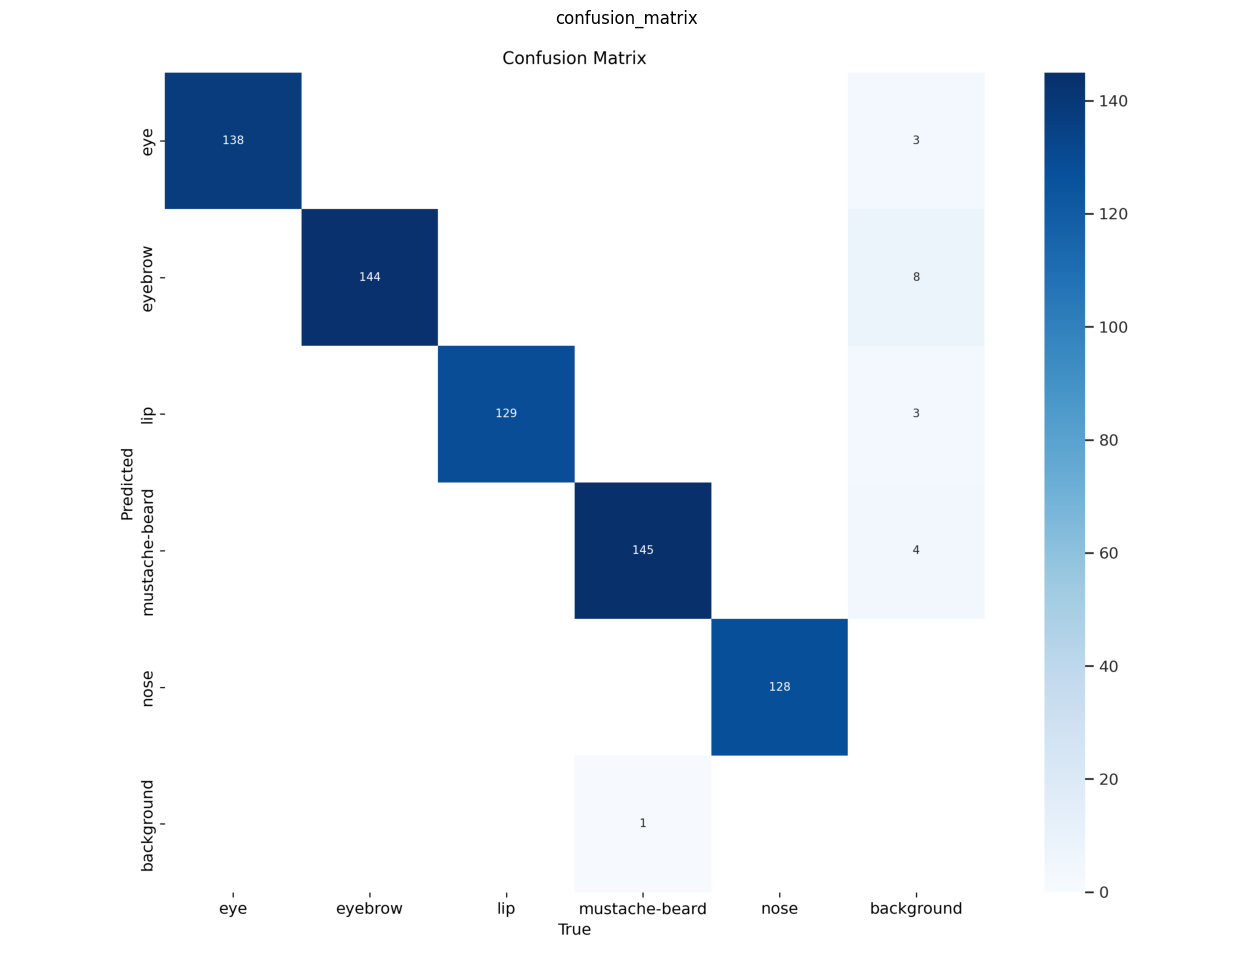

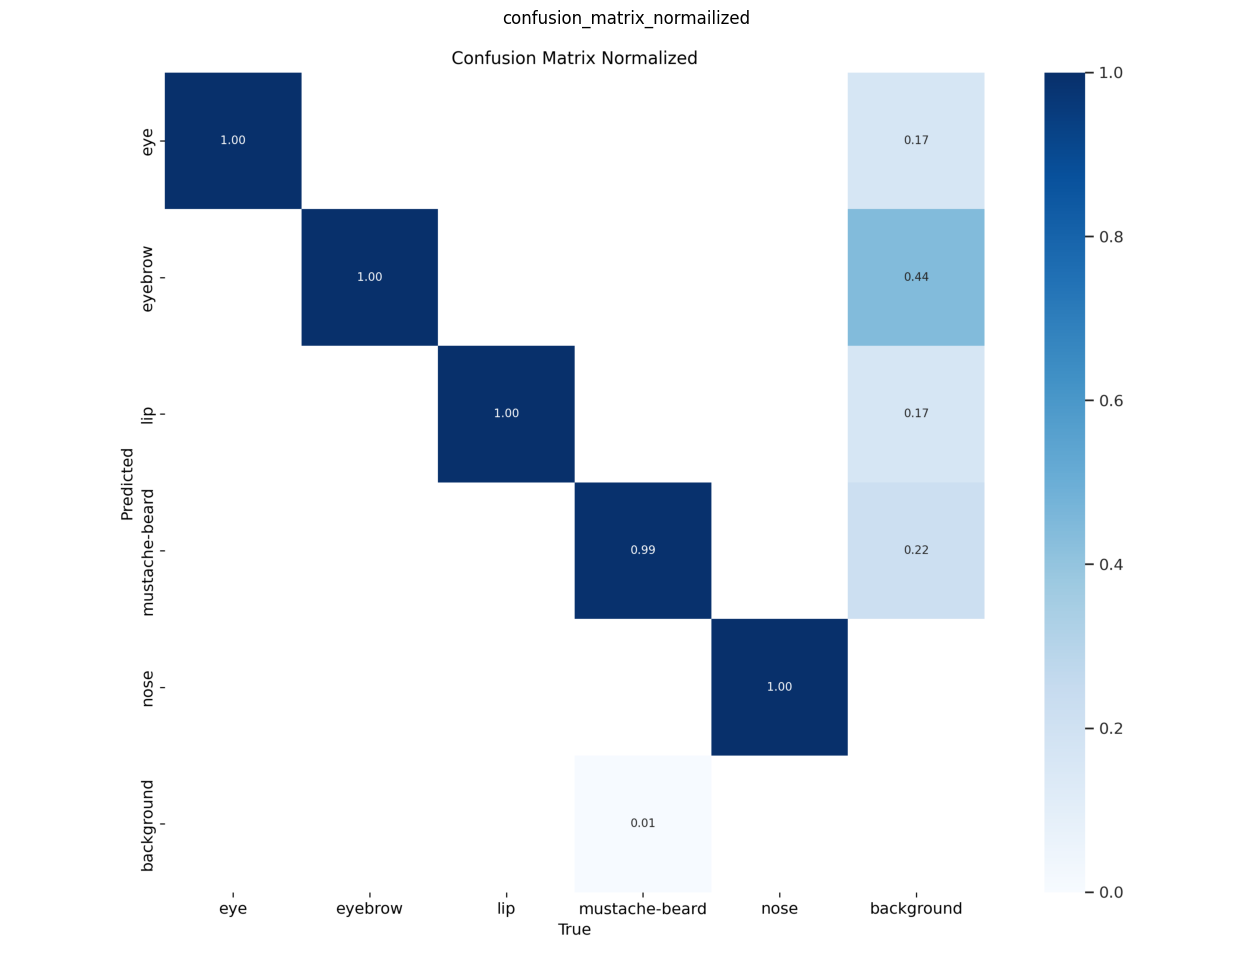

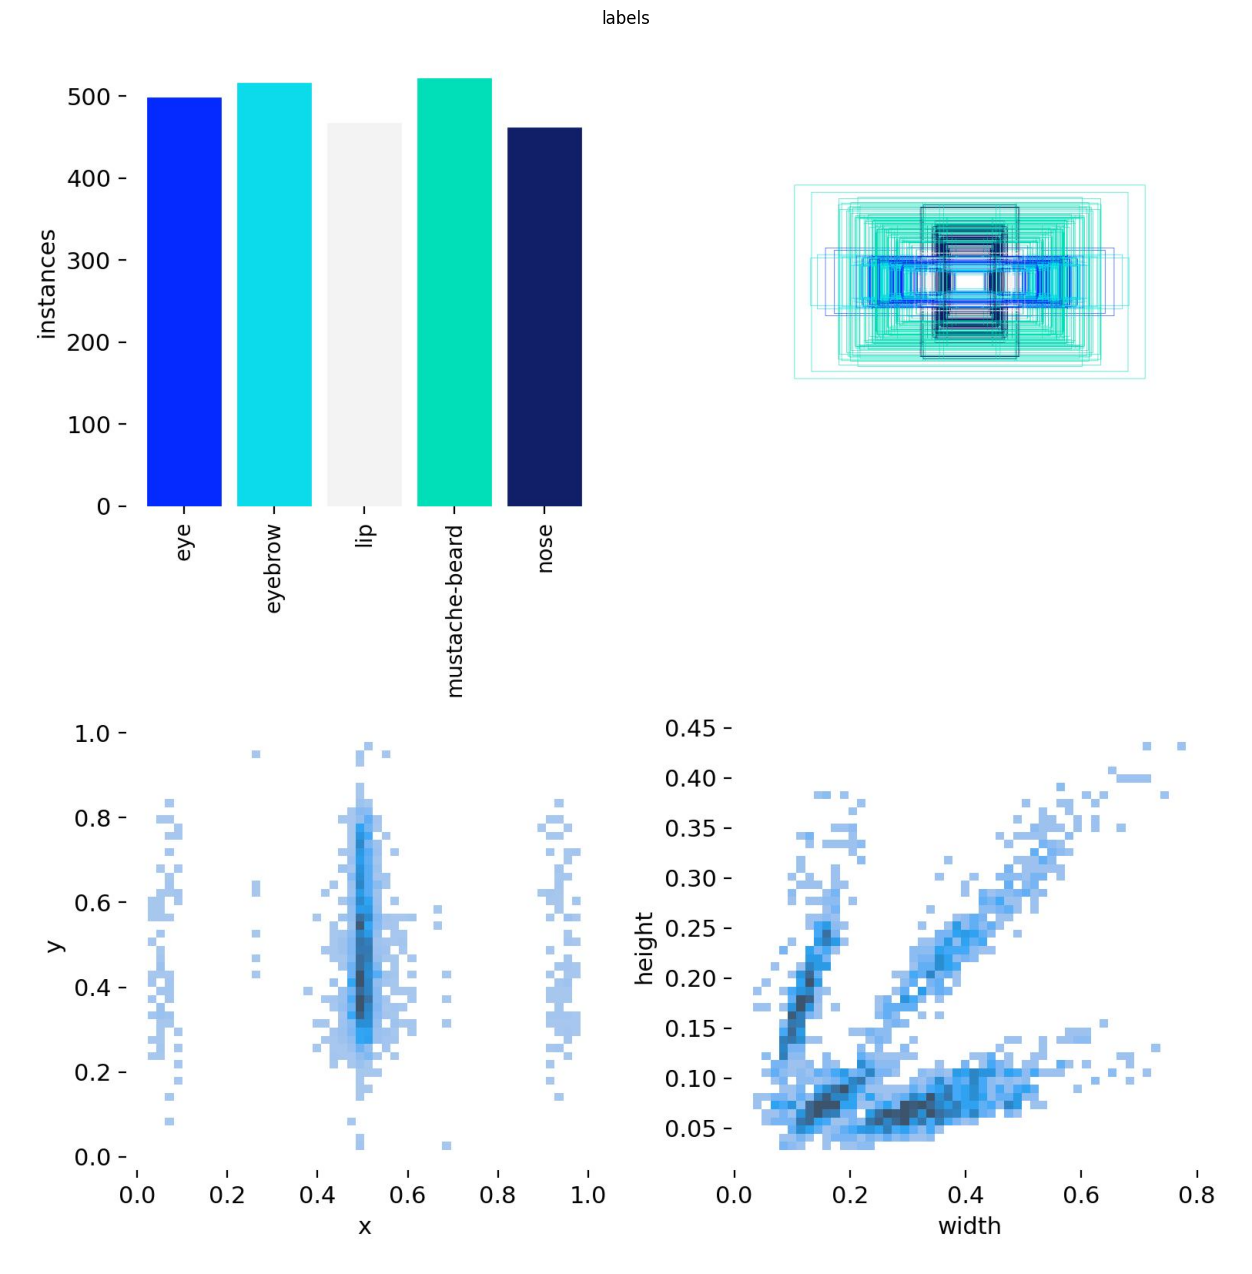

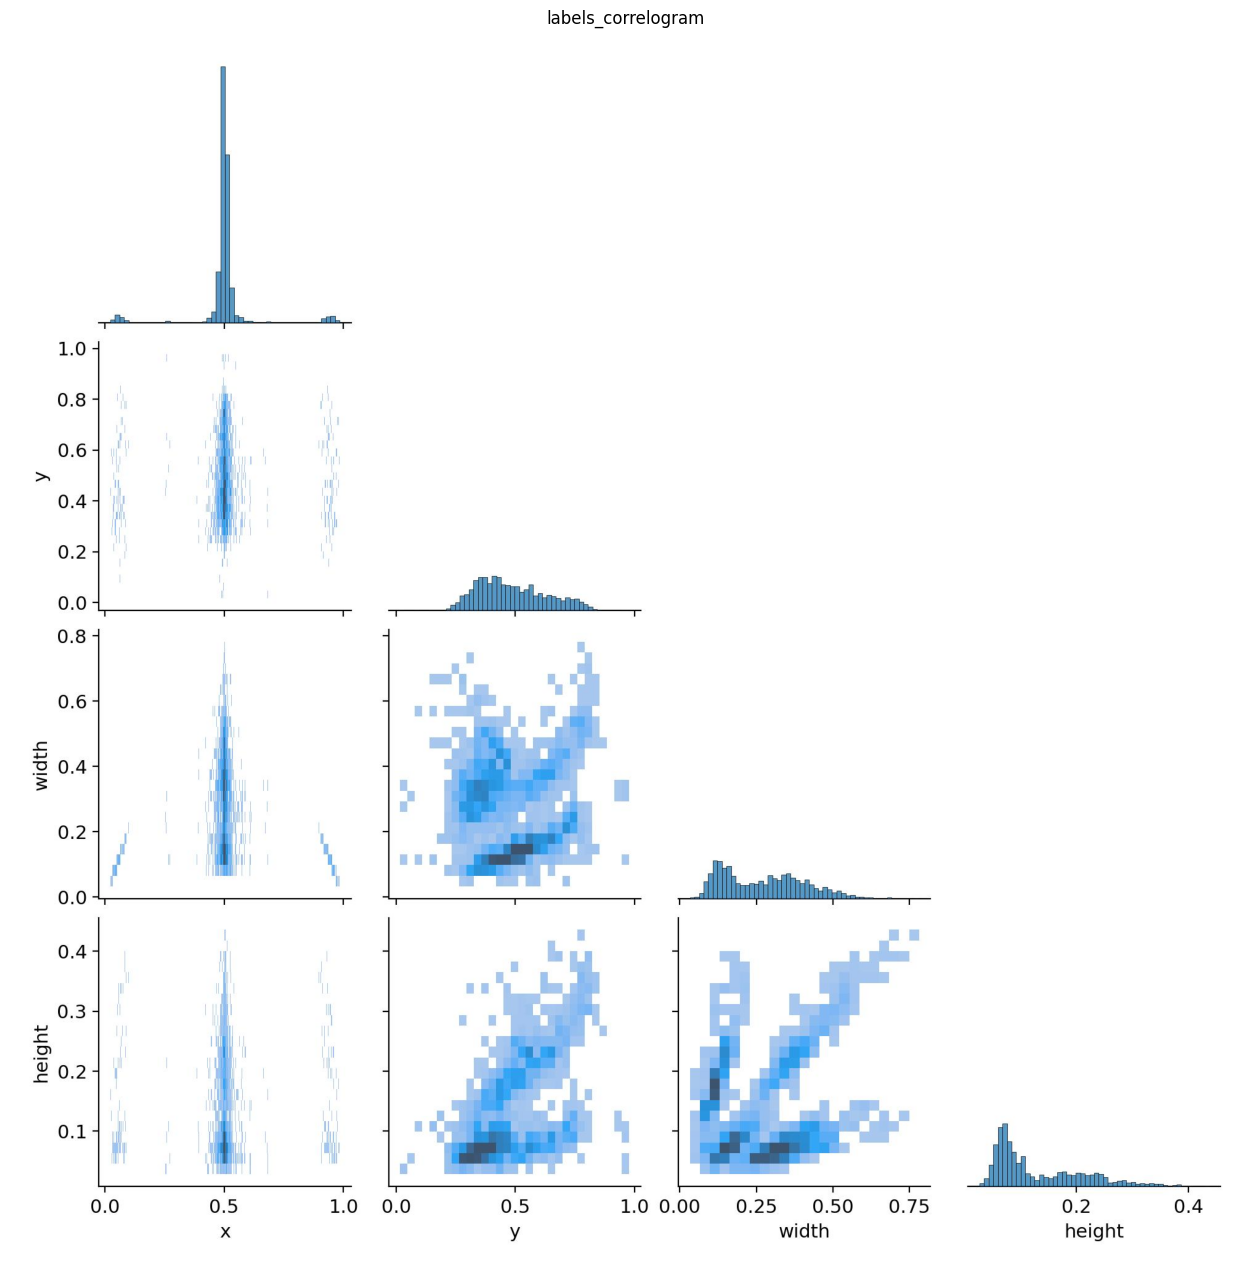

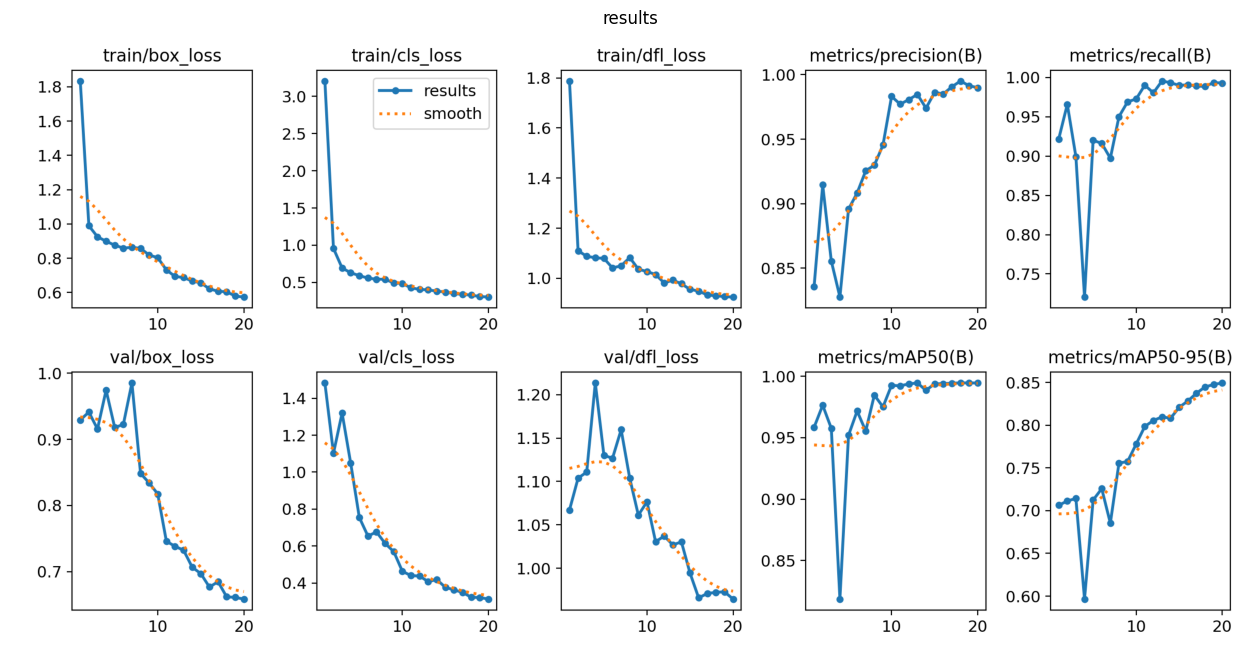

In [9]:
if __name__ == "__main__":
    main()